# Proton Beam Parameters for IOTA

This notebook documents rough calculations of basic parameters of the 2.5 MeV proton beam in IOTA including linear optics, tune shifts, beam lifetime and emittance growth rates from residual gas scattering and Intra-Beam Scattering (IBS). This document is based on previous work.

# Constants and Initialization

In [1]:
# Imports
import numpy as np # General numerics
import matplotlib.pyplot as plt # Plotting
%matplotlib inline
import pymadx # Loading TFS files from MAD-X
# Notebook rendering tools
from IPython.display import display
from IPython.display import display_latex
from IPython.display import display_markdown
from IPython.display import set_matplotlib_formats

# General initialization
set_matplotlib_formats('pdf', 'png')
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
colors = ['tab:red', 'tab:blue']

# Constants
pi = np.pi # \pi
sqrttwopi = np.sqrt(2*np.pi) # \sqrt{2\pi}
# Fundamental constants
c = 299792458 # Speed of light in m/s
m_e = 9.109383702e-31 # Electron mass in kg
m_p = 1.672621924e-27 # Proton mass in kg
q_e = 1.602176634e-19 # Electronic charge in C
epsilon_0 = 8.8541878128e-12 # Vacuum permittivity in (Nm^2)/C^2
kB = 1.38064852e-23 # Boltzmann constant in J/K
# Derived constants and units
r_e = q_e*q_e/(4*pi*epsilon_0*m_e*c*c) # Classical electron radius in m
r_p = q_e*q_e/(4*pi*epsilon_0*m_p*c*c) # Classical proton radius in m
eV = q_e; keV = 1e3*eV; MeV = 1e6*eV # eV in Joules
Torr = 133.3224 # Conversion constant from Torr to Pa

# Basic Parameters
The proton beam is generated at the injector and then bunched by the IOTA rf system.

In [2]:
# Proton Beam
T_b = 2.5*MeV # Bunch kinetic energy in J
M_b = m_p # Mass in kg
q_b = 0.565e-9 # Bunch charge in C
emittance_x = 4.3e-6 # x emittance (m)
emittance_y = 3e-6   # y emittance (m)
sigma_b_p = 1.32e-3    # rms momentum spread
sigma_b_s = 0.79413    # rms bunch length (m)

# Derived parameters
E_b = T_b + M_b*c**2 # Total energy in J
gamma_b = E_b/(M_b*c*c) # Relativistic gamma
beta_b = np.sqrt(1-gamma_b**(-2)) # Velocity/c
N_b = q_b/q_e # Number of particles in bunch

# Render a parameter table
metadata={'table': {'align':'@{}lr@{}',
                    'caption': 'Basic proton beam parameters in IOTA.'}}
display_markdown('| Parameter | Value |\n'
                 '|:---|---:|\n'
                 f'| Kinetic Energy ($T_b$) | {T_b/MeV:.1f} MeV |\n'
                 f'| RMS transverse emittance x ($\epsilon_x$) | {emittance_x*1e6:.2f} $\mu$m |\n'
                 f'| RMS transverse emittance y ($\epsilon_y$) | {emittance_y*1e6:.2f} $\mu$m |\n'
                 f'| RMS momentum spread ($\sigma_p$) | {sigma_b_p:.2e} |\n',
                 raw=True,metadata=metadata)

| Parameter | Value |
|:---|---:|
| Kinetic Energy ($T_b$) | 2.5 MeV |
| RMS transverse emittance x ($\epsilon_x$) | 4.30 $\mu$m |
| RMS transverse emittance y ($\epsilon_y$) | 3.00 $\mu$m |
| RMS momentum spread ($\sigma_p$) | 1.32e-03 |


# Linear Optics
The IOTA lattice can be tuned for different linear optics configurations depending on the specific experiments. Relevant to proton beam operations, the lattice incorporates an electron-lens (e-lens) in the E-right section which will be used for non-linear optics and electron cooling. The e-lens consists of a low energy unbunched electron beam co-propagating with the proton beam and a solenoid used to focus the low energy electron beam. This solenoid breaks the left-right symmetry of the lattice producing slightly asymetric optics functions. The re-circulating beam inside the solenoid has a circular cross section which is required to achieve a non-linear integrable lattice and dispersion is suppressed in it.

pymadx.Tfs.Load> normal file
pymadx.Tfs.Load> normal file


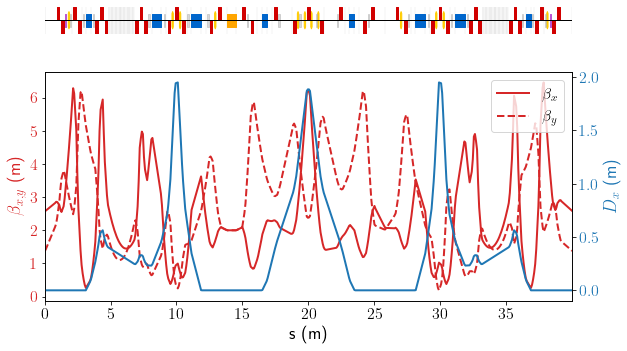

| Parameter | Value |
|:---|---:|
| Circumference (C) | 2.5 MeV |
| Harmonic Number (h) | 4 |
| Acceptance x y ($\epsilon_{mx,my}$) | 70.00, 70.00 $\mu$m |
| Maximum beta functions x y ($\beta_{x,y}$) | 6.65, 6.35 m |
| Maximum dispersion in x ($D_x$) | 1.95 m |


In [3]:
# Import lattice and computed twiss parameters from a TFS file generated by MAD-X.
lattice_file = 'proton_calc.tfs'
IOTA_proton_lat = pymadx.Data.Tfs(lattice_file)
s_lat      = [ele['S'] for ele in IOTA_proton_lat] # s coords
# Selected linear optics fiunctions
beta_lat_x  = [ele['BETX'] for ele in IOTA_proton_lat]
beta_lat_y  = [ele['BETY'] for ele in IOTA_proton_lat]
alpha_lat_x = [ele['ALFX'] for ele in IOTA_proton_lat]
alpha_lat_y = [ele['ALFY'] for ele in IOTA_proton_lat]
# MAD-X uses a derivartive w.r.t to PT = BETA*DELTAP.
# So multiply with beta to get standard dispersion funcions
disp_lat_x = [ele['DX']*beta_b for ele in IOTA_proton_lat]
dispp_lat_x = [ele['DPX']*beta_b for ele in IOTA_proton_lat] # Prime
# Some lattice parameters
C = s_lat[-1] # Circumference in m
# Harmonic number for RF cavity
h = [ele['HARMON'] for ele in IOTA_proton_lat if\
     ele['KEYWORD'] == 'RFCAVITY']; h = h[0]
# Beam current
I_b = h*q_b*c*beta_b/C
# Interpolate to create smoothed plot data
s_plot = np.linspace(0,C,500) # Plot axis
beta_lat_x_plot  = np.interp(s_plot, s_lat, beta_lat_x)
beta_lat_y_plot  = np.interp(s_plot, s_lat, beta_lat_y)
alpha_lat_x_plot = np.interp(s_plot, s_lat, alpha_lat_x)
alpha_lat_y_plot = np.interp(s_plot, s_lat, alpha_lat_y)
disp_lat_x_plot  = np.interp(s_plot, s_lat, disp_lat_x)
dispp_lat_x_plot = np.interp(s_plot, s_lat, dispp_lat_x)
# Should import this directly from the lattice but hard code for now
acceptance_x = 7e-5 # $\epsilon_{mx}$ in m
acceptance_y = 7e-5 # $\epsilon_{my}$ in m

# Plot the optics functions
s_plot = np.linspace(0,40,500) # Number of points in plot
fig, ax1 = plt.subplots() # Generate subplots
fig.set_size_inches(9, 5) # Nice size 9 in x 5 in
# Plot beta functions on left axis
ax1.plot(s_plot, beta_lat_x_plot, color=colors[0], label='$\\beta_x$')
ax1.plot(s_plot, beta_lat_y_plot, color=colors[0],
         linestyle='--', label='$\\beta_y$')
# Label plots
ax1.set_xlabel('s (m)')
ax1.set_ylabel('$\\beta_{x,y}$ (m)', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])
ax1.legend()
ax2 = ax1.twinx() # Plot dispersion on right axis
ax2.plot(s_plot, disp_lat_x_plot, color=colors[1])
ax2.set_ylabel('$D_x$ (m)', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])
# Add a lattice key to the plot
pymadx.Plot.AddMachineLatticeToFigure(fig, lattice_file)
metadata={'caption': 'Optics functions for the IOTA lattice in the electron lens configuration.'}
display(fig, metadata=metadata)
plt.close()

# Render a parameter table
metadata={'table': {'align':'@{}lr@{}',
                    'caption': 'IOTA lattice parameters.'}}
display_markdown('| Parameter | Value |\n'
                 '|:---|---:|\n'
                 f'| Circumference (C) | {T_b/MeV:.1f} MeV |\n'
                 f'| Harmonic Number (h) | {h:.0f} |\n'
                 f'| Acceptance x y ($\epsilon_{{mx,my}}$) | {acceptance_x*1e6:.2f}, {acceptance_x*1e6:.2f} $\mu$m |\n'
                 f'| Maximum beta functions x y ($\\beta_{{x,y}}$) | {np.max(beta_lat_x):.2f}, {np.max(beta_lat_y):.2f} m |\n'
                 f'| Maximum dispersion in x ($D_x$) | {np.max(disp_lat_x):.2f} m |\n',
                 raw=True,metadata=metadata)

# Residual Gas Scattering
Particles constituting the beam can scatter off the nuclei of residual gas inside the vacuum chamber. If a particle in the beam gets scattered by a relatively large angle, then it might hit the beam pipe and be lost. This is an important loss mechanism in IOTA and determines the lifetime of the beam. The threshold value $\theta_\mathrm{tr}$ of scattering angle beyond which particles will be lost is,
\begin{equation}
\theta_\mathrm{tr} = \frac{1}{\sqrt{\frac{1}{2}\bigg( \frac{\beta^{lat}_{x_{max}}}{\epsilon_{mx}} + \frac{\beta^{lat}_{y_{max}}}{\epsilon_{my}}\bigg)}}\,,
\end{equation}
where $\beta^{lat}_{x_{max}}$, $\beta^{lat}_{y_{max}}$ are the maximum beta functions and $\epsilon_{mx}$, $\epsilon_{my}$ are the acceptances of the ring in the horizontal and vertical planes respectively. The Coulomb scattering differential cross-section of a nucleus with charge $Ze$ at rest as seen by an incomming proton is,
\begin{equation}
\frac{\mathrm{d}\sigma}{\mathrm{d}\Omega} = \frac{Z(Z+1)r_e^2}{4} \Big( \frac{m_e c}{\beta p} \Big)^2 \frac{1}{\sin^4 \frac{\theta}{2}} \bigg( 1 - \beta^2 \sin^2 \frac{\theta}{2}\bigg)\,,
\end{equation}
where $p$ is the momentum of the incoming proton. Consequently, the total cross-section of collisions which could result in particle loss is,
\begin{equation}
\sigma_\mathrm{RGS}(\theta_{tr},Z) = \int\limits_{\theta_\mathrm{tr}}^\pi \frac{\mathrm{d}\sigma}{\mathrm{d}\Omega}(\theta) \sin \theta \mathrm{d} \theta = \frac{\pi r_p^2 Z(Z+1)}{\beta^4\gamma^2} \bigg\{ \cot^2\frac{\theta_\mathrm{tr}}{2} - \beta^2 \ln \big( \mathrm{cosec}^2 \frac{\theta_\mathrm{tr}}{2} \big) \bigg\} \approx \frac{4\pi r_p^2 Z(Z+1)}{\beta^4\gamma^2 \theta_\mathrm{tr}^2}\,,
\end{equation}
where the approximation applies when $\theta_{tr}$ is small. Finally the total rate of such scattering events depend on the number density $n_i$ of gas atoms with atomic number $Z_i$, the respective cross sections $\sigma_\mathrm{RGS}$ and the velocity of the particles in the beam $v$. Combining the scattering rates from all atoms, we get the beam lifetime as
\begin{equation}
\tau_\mathrm{RGS,single}^{-1} = \sum_i v n_i \sigma_\mathrm{RGS}(\theta_{tr},Z_i) =  \frac{2\pi c r_p^2}{\beta^3\gamma^2 } \bigg( \frac{\beta^{lat}_{x_{max}}}{\epsilon_{mx}} + \frac{\beta^{lat}_{y_{max}}}{\epsilon_{my}}\bigg) \sum_i n_i Z_i (Z_i + 1)\,.
\end{equation}
The atoms typically present inside an accelerator vacuum system are H, C, O and Ar. Based on measurements using a residual gas analyzer, we can determine the lifetime of the IOTA proton beam.


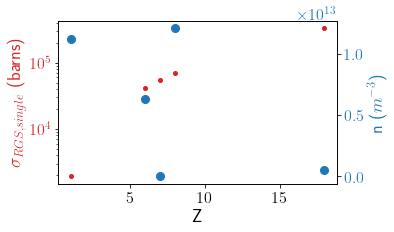

In [4]:
# IOTA vacuum composition
Z_i = np.array([1,6,7,8,18]) # Atomic numbers of H, C, N, O and Ar
P_IOTA = 1.57e-10*Torr # Total pressure in Pa
T_IOTA = 298 # Room temperature in K
# Fractions of gases
p = {'H':0, 'H2':0.5, 'CO':0.5, 'H2O':0.5, 'C2H2':0, 'CH4':0.05, 'CO2':0.69, 'Ar':0.1}

# Number density of atoms
n_IOTA = P_IOTA/(kB*T_IOTA)
p_i = np.zeros(5) # Partial pressures of all atoms
p_i[0] = p['H'] + 2*p['H2'] + 2*p['H2O'] + 2*p['C2H2'] + 4*p['CH4']
p_i[1] = p['CO'] + 2*p['C2H2'] + p['CH4'] + p['CO2']
p_i[2] = 0
p_i[3] = p['CO'] + p['H2O'] + 2*p['CO2']
p_i[4] = p['Ar']
# Number density of all atoms in m^{-3}
n_i = P_IOTA*p_i/(kB*T_IOTA)

# Threshold angle for beam loss in rad
theta_tr = 1/np.sqrt((np.max(beta_lat_x)/acceptance_x + np.max(beta_lat_y)/acceptance_y)/2)
# Cross section for all atoms in m^2
sigma_RGS = 4*pi*r_p*r_p*Z_i*(Z_i+1)/(beta_b**4 * gamma_b**2 * theta_tr**2)

# Beam lifetime from single Coulomb scattering in seconds
tau_RGS_single = 1/(sum(n_i*sigma_RGS)*c*beta_b)
#tau_RGS_single = beta_b**3*gamma_b**2/(2*pi*c*r_p*r_p*n_eff*(beta_lat_x_max/acceptance_x + beta_lat_y_max/acceptance_y))

# Produce outputs
fig, ax1 = plt.subplots()
fig.set_size_inches(5, 3) # Nice size 5 in x 3 in
ax1.plot(Z_i, sigma_RGS*1e28, color=colors[0], marker='.', linestyle='None')
plt.yscale('log')
ax1.set_xlabel('Z')
ax1.set_ylabel('$\sigma_{RGS,single}$ (barns)', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])
ax2 = ax1.twinx()
ax2.plot(Z_i, n_i, color=colors[1], marker='o', linestyle='None')
ax2.set_ylabel('n ($m^{-3}$)', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])
metadata={'caption': 'Number density and cross sections of proton scattering for different gas nuclei.'}
display(fig, metadata=metadata)
plt.close()

While single scattering events with a large deflection angle can lead to beam loss, multiple small angle Coulomb scattering events can increase the beam emittance. In this case, a particle traveling through a section of the vacuum system gets scattered repeatedly, each time getting a transverse kick $\delta x' = \theta_k \cos \phi$ and $\delta y' = \theta_k \sin \phi$, where $\theta_k$ is the scattering angle and $\phi$ denotes the angle between the plane of scattering and the $z-x$ plane. The mean square kick $\langle (\delta x')^2 \rangle$ in the $z-x$ plane accumulated per unit time is,
\begin{equation}
\frac{\mathrm{d}\langle (\delta x')^2 \rangle}{\mathrm{d}t} = nv\int\limits_0^{2\pi} \mathrm{d}\phi\, \int\limits_{\theta_\text{min}}^{\theta_\text{max}} \sin \theta \mathrm{d}\theta\, \frac{\mathrm{d}\sigma}{\mathrm{d}\Omega}(\theta) (\theta \cos \phi)^2\,,
\end{equation}
where $n$ is the number density of the scattering nuclei, $v$ is the velocity of the proton beam, $\theta_\text{min}$ and $\theta_\text{max}$ are the limits of scattering angle under consideration. Redefining the differential cross-section in terms of the impact parameter $b$, and integrating over $\phi$ gives,
\begin{equation}
\frac{\mathrm{d}\langle (\delta x')^2 \rangle}{\mathrm{d}t} = nv\pi \int\limits_{b_\text{min}}^{b_\text{max}} b \theta^2(b)\,\mathrm{d}b \approx \frac{4\pi c r_p^2}{\beta^3\gamma^2 } nZ(Z+1) L_c\,,
\end{equation}
where we have approximated for small scattering angles, and $L_c \equiv \ln (b_\text{max}/b_\text{min})$ is called the Coulomb logarithm. The coresponding rate of increase in emittance in a region with constant beta function $\beta_x$ is $\mathrm{d}\epsilon_x/\mathrm{d}t = 1/2 \beta_x \mathrm{d}\langle (\delta x')^2 \rangle/\mathrm{d}t$. Summing up the contribution from all atoms inside the vacuum system, the net rate of increase in emittance over the whole ring is,
\begin{equation}
\frac{\mathrm{d} \epsilon_x}{\mathrm{d}t} = \frac{2\pi c r_p^2}{\beta^3\gamma^2 } \langle \beta_x \rangle \sum_i n_i Z_i (Z_i+1) L_{c_i}\,,
\end{equation}
where we have assumed an uniform vacuum composition throughout the ring with atoms of atomic number $Z_i$ having number density $n_i$ and $\langle \beta_x \rangle$ is the average beta function around the ring. The Coulomb logarithm is set to $L_{c_i} = \ln (204/\sqrt[3]{Z_i})$. A similar calculation of the emittance growth in the $y-z$ plane gives the same result. Finally, the emittance growth time scales in the transverse planes are defined as,
\begin{equation}
\tau_\mathrm{RGS,\epsilon_{x,y}}^{-1} \equiv \frac{\mathrm{d}\epsilon_{x,y}/\mathrm{d}t}{\epsilon_{x,y}} = \frac{2\pi c r_p^2}{\beta^3\gamma^2 \epsilon_{x,y}} \langle \beta_{x,y} \rangle \sum_i n_i Z_i (Z_i+1) \ln \frac{204}{\sqrt[3]{Z_i}}
\end{equation}

In [5]:
# Multiple scattering
# Transverse kinetic energy growth rate due to each species
dktrans_dt = 4*pi*c * r_p**2 * n_i*Z_i*(Z_i+1)*np.log(204/(Z_i**(1/3)))/(beta_b**3 * gamma_b**2)
# Net emittance growth times
tau_RGS_emittance_x = 2*emittance_x/(np.mean(beta_lat_x_plot)*np.sum(dktrans_dt))
tau_RGS_emittance_y = 2*emittance_y/(np.mean(beta_lat_y_plot)*np.sum(dktrans_dt))

# Render a parameter table
metadata={'table': {'align':'@{}lr@{}',
                    'caption': 'Timescales associated with residual gas scattering assuming vacuum conditions same as run 2.'}}
display_markdown('| Timescales | Value |\n'
                 '|:---|---:|\n'
                 f'| $\\tau_\mathrm{{RGS,single}}$ | {tau_RGS_single:.2f} s |\n'
                 f'| $\\tau_\mathrm{{RGS,\epsilon_x}}$ | {tau_RGS_emittance_x:.2f} s |\n'
                 f'| $\\tau_\mathrm{{RGS,\epsilon_y}}$ | {tau_RGS_emittance_y:.2f} s |\n',
                 raw=True,metadata=metadata)

| Timescales | Value |
|:---|---:|
| $\tau_\mathrm{RGS,single}$ | 353.81 s |
| $\tau_\mathrm{RGS,\epsilon_x}$ | 25.53 s |
| $\tau_\mathrm{RGS,\epsilon_y}$ | 15.71 s |


# Tune Shifts
Brief explanation here.

In [6]:
# Beam sizes as a function of s position
sigma_b_x = np.sqrt(emittance_x*beta_lat_x_plot + (disp_lat_x_plot*sigma_b_p)**2)
sigma_b_y = np.sqrt(emittance_y*beta_lat_y_plot)

# Tune shift prefactor
delta_nu_sc_prefactor = r_p*N_b/(2*pi * beta_b**2 * gamma_b**3 * 
                                 sqrttwopi * sigma_b_s)
# Tune shifts
delta_nu_sc_x = -delta_nu_sc_prefactor * \
    np.mean(C*beta_lat_x_plot/(sigma_b_x*(sigma_b_x+sigma_b_y)))
delta_nu_sc_y = -delta_nu_sc_prefactor * \
    np.mean(C*beta_lat_y_plot/(sigma_b_y*(sigma_b_x+sigma_b_y)))

# Render a parameter table
metadata={'table': {'align':'@{}lr@{}',
                    'caption': 'Bunch charge and betatron tune shifts due to direct space charge.'}}
display_markdown('| Parameters | Value |\n'
                 '|:---|---:|\n'
                 f'| Bunch charge ($q_b$) | {q_b*1e9:.2f} nC |\n'
                 f'| $\\nu_{{SC,x}}$ | {delta_nu_sc_x:.2f} |\n'
                 f'| $\\nu_{{SC,y}}$ | {delta_nu_sc_y:.2f} |\n',
                 raw=True,metadata=metadata)

| Parameters | Value |
|:---|---:|
| Bunch charge ($q_b$) | 0.57 nC |
| $\nu_{SC,x}$ | -0.38 |
| $\nu_{SC,y}$ | -0.50 |


# Intra Beam Scattering
Add quick explanation here.

pymadx.Tfs.Load> normal file


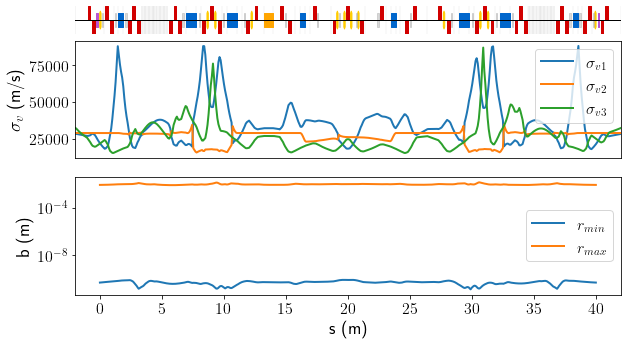

In [7]:
# All calculations are done on uniformly spaced points on s
# Beam and lattice properties around the ring
# Local beam divergence
theta_b_x = np.sqrt(emittance_x/beta_lat_x_plot)
theta_b_y = np.sqrt(emittance_y/beta_lat_y_plot)
theta_b_p = sigma_b_p/gamma_b # Longitudinal divergence
# Quantities calculated from linear optics functions
Phi_lat_x = dispp_lat_x_plot + alpha_lat_x_plot*disp_lat_x_plot/beta_lat_x_plot

# Set up some variables for IBS calculation
sigma_b_vd = np.zeros([len(s_plot),3])
rminmax = np.zeros([len(s_plot),2])
# For each point on the lattice
for ii in range(len(s_plot)):
    Sigma_IBS = np.zeros([3,3]) # Second moment of velocity distribution in BF
    # Calculate the \Sigma elements, skip the premultiplier (gamma_b*beta_b*c)**2
    Sigma_IBS[0,0] = (theta_b_x[ii]**2)*\
        (1+(sigma_b_p*beta_lat_x_plot[ii]*Phi_lat_x[ii]/sigma_b_x[ii])**2)
    Sigma_IBS[0,2] = (sigma_b_p**2)*emittance_x*beta_lat_x_plot[ii]*\
        Phi_lat_x[ii]/(gamma_b*sigma_b_x[ii]**2)
    Sigma_IBS[1,1] = theta_b_y[ii]**2
    Sigma_IBS[2,0] = Sigma_IBS[0,2]
    Sigma_IBS[2,2] = (theta_b_p**2)*emittance_x*beta_lat_x_plot[ii]/(sigma_b_x[ii]**2)
    w, v = np.linalg.eig(Sigma_IBS) # Find eigenvalues and vectors
    # Eigen-velocity distributions
    sigma_b_vd[ii,:] = np.sqrt(w)*gamma_b*beta_b*c
    # Range of impact parameters to consider
    rminmax[ii,0] = r_p/(np.sum(w)*(gamma_b*beta_b)**2)
    rminmax[ii,1] = np.sqrt(sqrttwopi*sigma_b_x[ii]*sigma_b_y[ii]*sigma_b_s/(rminmax[ii,0]*N_b))
    Lc = np.log(rminmax[ii,1]/rminmax[ii,0])

# Make plots.
# Velocity distribution and impact parameter ranges.
fig, axs = plt.subplots(2,1);
fig.set_size_inches(9, 5) # Nice size 9 in x 5 in
axs[0].plot(s_plot, sigma_b_vd)
axs[0].axes.xaxis.set_visible(False); axs[0].set_ylabel('$\sigma_v$ (m/s)')
axs[0].legend(['$\sigma_{v1}$','$\sigma_{v2}$','$\sigma_{v3}$'])
axs[1].plot(s_plot, rminmax); plt.yscale('log')
axs[1].legend(['$r_{min}$','$r_{max}$'])
axs[1].set_xlabel('s (m)'); axs[1].set_ylabel('b (m)');
# Add a lattice key to the plot
pymadx.Plot.AddMachineLatticeToFigure(fig, lattice_file)
metadata={'caption': 'RMS particle velocities and impact parameter ranges throughout the IOTA ring.'}
display(fig, metadata=metadata)
plt.close()